# Directory settings

# About this notebook

The goal of this notebook is to improve the results of the [notebook](https://www.kaggle.com/code/cdeotte/efficientnetb0-starter-lb-0-43#Train-DataLoader) shared by @cdeotte and [@alejopaullier](https://www.kaggle.com/code/alejopaullier/hms-efficientnetb0-pytorch-train), please check them out great notebooks.


**Important note**:

I shared in the last days a [discussion](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/478474) which was an Improvement of this [notebook](https://www.kaggle.com/code/nischaydnk/hms-submission-1d-eegnet-pipeline-lightning) created by @nischaydnk. The tricks I used were notably changing the optimizer (I used Adan) and I used the two stage training as stated by @seanbearden [here](https://www.kaggle.com/code/seanbearden/effnetb0-2-pop-model-train-twice-lb-0-39) and not using downsampling which worked pretty well.
But the two stage training an issue which is data leakage. The idea was to seperate the data with few votes because the kl will hardly penalize the model if it mislabel them. So in my previous experiments I use two groupkfold CV on the two datasets and the samples with few votes are present in both datasets.

So in this notebook, I use one CV scheme and in each stage I filter the data then validate on the data that contains both population to prevent data leakage. Let me know in the comment if this approach is correct more info can be found [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477461).

As stated [here](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/477498), adding 0.166666667 to the targets will reduce the CV/LB gap.

**Consider upvoting this notebook if you find it useful**

## Version 1
* I train a tf_efficientnet_b0_ns model.

### Hyperparams

```
scheduler='OneCycleLR' 
 # OneCycleLR params
  cosanneal_res_params={
      'T_0':20,
      'eta_min':1e-6,
      'T_mult':1,
      'last_epoch':-1}
  print_freq=50
  num_workers = 1
  model_name = 'tf_efficientnet_b0_ns'
  optimizer='Adam'
  stage1_epochs = 5
  stage1_epochs = 7
  eps = 1e-6
  lr = 1e-3
  batch_size = 128
  weight_decay = 1e-2
  seed = 2024
```

## Version2

* I changed the CV sheme, first stage train on all data second stage train on data with `total_evaluators >= 10`
* Added Time masking augmentation from [here](https://www.kaggle.com/code/iglovikov/xymasking-aug).

### Hyperparams

```
scheduler='OneCycleLR' 
 # OneCycleLR params
  cosanneal_res_params={
      'T_0':20,
      'eta_min':1e-6,
      'T_mult':1,
      'last_epoch':-1}
  print_freq=50
  num_workers = 1
  model_name = 'tf_efficientnet_b0_ns'
  optimizer='Adam'
  stage1_epochs = 5
  stage1_epochs = 5
  eps = 1e-6
  lr = 1e-3
  batch_size = 64
  weight_decay = 1e-2
  seed = 2024
```

## Version3

* removed the `0.166667` hack
* added mixup and hflip augmentations

```
scheduler='OneCycleLR' 
 # OneCycleLR params
  cosanneal_res_params={
      'T_0':20,
      'eta_min':1e-6,
      'T_mult':1,
      'last_epoch':-1}
  print_freq=50
  num_workers = 1
  model_name = 'tf_efficientnet_b0_ns'
  optimizer='Adam'
  stage1_epochs = 5
  stage1_epochs = 5
  eps = 1e-6
  lr = 1e-3
  batch_size = 64
  weight_decay = 1e-2
  seed = 2024
```

In [1]:
# !pip install -U albumentations

In [2]:
# ====================================================
# directory settings
# ====================================================

import os

DATA_ROOT = "/mnt/e/Workspace/IDL/Data/project"
MODEL_ROOT = "/mnt/e/Workspace/IDL/Models/project/baseline"

OUTPUT_DIR = f'{MODEL_ROOT}'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
    
POP_2_DIR = OUTPUT_DIR + 'pop_2_weight_oof/'
if not os.path.exists(POP_2_DIR):
    os.makedirs(POP_2_DIR)
    
POP_1_DIR = OUTPUT_DIR + 'pop_1_weight_oof/'
if not os.path.exists(POP_1_DIR):
    os.makedirs(POP_1_DIR)

# Libraries

In [3]:
import os
import gc
from glob import glob
import sys
import math
import time
import random
import shutil
from pathlib import Path
from typing import Dict, List
from scipy.stats import entropy
from scipy.signal import butter, lfilter, freqz
from contextlib import contextmanager
from collections import defaultdict, Counter

from kaggle_kl_div import score
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, log_loss
from tqdm.auto import tqdm
from functools import partial
import cv2
from PIL import Image
import torch
import torch.nn as nn
import pytorch_lightning as pl
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
import torchvision.models as models
from torch.nn.parameter import Parameter
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR, CosineAnnealingLR, CosineAnnealingWarmRestarts
from sklearn.preprocessing import LabelEncoder
from torchvision.transforms import v2
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations import (Compose, Normalize, Resize, RandomResizedCrop, HorizontalFlip, VerticalFlip, ShiftScaleRotate, Transpose)
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform
import timm
import warnings 
warnings.filterwarnings('ignore')
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from matplotlib import pyplot as plt
import joblib
VERSION=3

/home/zzy/miniconda3/envs/11785/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [4]:
# ====================================================
# CFG
# ====================================================

class CFG:
    wandb = False
    debug = False
    train=True
    apex=True
    stage1_pop1=True
    stage2_pop2=False
    VISUALIZE=True
    FREEZE=False
    SparK=False
    t4_gpu=False
    USE_MIXUP = True
    scheduler='OneCycleLR' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts','OneCycleLR']
    # CosineAnnealingLR params
    cosanneal_params={
        'T_max':6,
        'eta_min':1e-5,
        'last_epoch':-1
    }
    #ReduceLROnPlateau params
    reduce_params={
        'mode':'min',
        'factor':0.2,
        'patience':4,
        'eps':1e-6,
        'verbose':True
    }
    # CosineAnnealingWarmRestarts params
    cosanneal_res_params={
        'T_0':20,
        'eta_min':1e-6,
        'T_mult':1,
        'last_epoch':-1
    }
    print_freq=50
    num_workers = 1
    model_name = 'tf_efficientnet_b0_ns'
    optimizer='Adan'
    epochs = 5
    factor = 0.9
    patience = 2
    eps = 1e-6
    lr = 1e-3
    min_lr = 1e-6
    batch_size = 32
    weight_decay = 1e-2
    batch_scheduler=True
    gradient_accumulation_steps = 1
    max_grad_norm = 1e7
    seed = 2024
    target_cols = ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
    target_size = 6
    pred_cols = ['pred_seizure_vote', 'pred_lpd_vote', 'pred_gpd_vote', 'pred_lrda_vote', 'pred_grda_vote', 'pred_other_vote']
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    PATH = f'{DATA_ROOT}/hms-harmful-brain-activity-classification/'
    data_root = "/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/"
    raw_eeg_path = "/kaggle/input/brain-eegs/eegs.npy"

# Utils

In [5]:
def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()

def get_score(preds, targets):
    oof = pd.DataFrame(preds.copy())
    oof['id'] = np.arange(len(oof))

    true = pd.DataFrame(targets.copy())
    true['id'] = np.arange(len(true))

    cv = score(solution=true, submission=oof, row_id_column_name='id')
    return cv

def butter_bandpass(lowcut, highcut, fs, order=5):
    return butter(order, [lowcut, highcut], fs=fs, btype='band')

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y


def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

class KLDivLossWithLogits(nn.KLDivLoss):

    def __init__(self):
        super().__init__(reduction="batchmean")

    def forward(self, y, t):
        y = nn.functional.log_softmax(y,  dim=1)
        loss = super().forward(y, t)

        return loss



def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    
seed_torch(seed=CFG.seed)

# Load train data

In [6]:
train = pd.read_csv(f'{DATA_ROOT}/hms-harmful-brain-activity-classification/train.csv')
TARGETS = train.columns[-6:]
print('Train shape:', train.shape )
print('Targets', list(TARGETS))

train['total_evaluators'] = train[['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']].sum(axis=1)

print(f'There are {train.patient_id.nunique()} patients in the training data.')
print(f'There are {train.eeg_id.nunique()} EEG IDs in the training data.')

Train shape: (106800, 15)
Targets ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
There are 1950 patients in the training data.
There are 17089 EEG IDs in the training data.


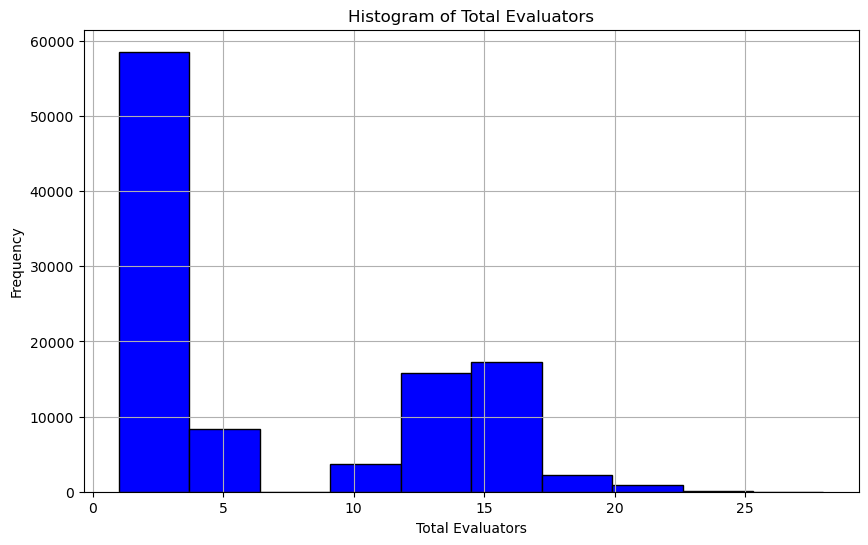

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [8]:
%%time
spectrograms = np.load(f'{DATA_ROOT}/brain-spectrograms/specs.npy', allow_pickle=True).item()

CPU times: user 153 ms, sys: 3.47 s, total: 3.63 s
Wall time: 25.4 s


In [9]:
%%time
all_eegs = np.load(f'{DATA_ROOT}/eeg-spectrogram-by-lead-id-unique/eeg_specs.npy',allow_pickle=True).item()

CPU times: user 289 ms, sys: 3.69 s, total: 3.98 s
Wall time: 35.2 s


# Deduplicate Train EEG Id

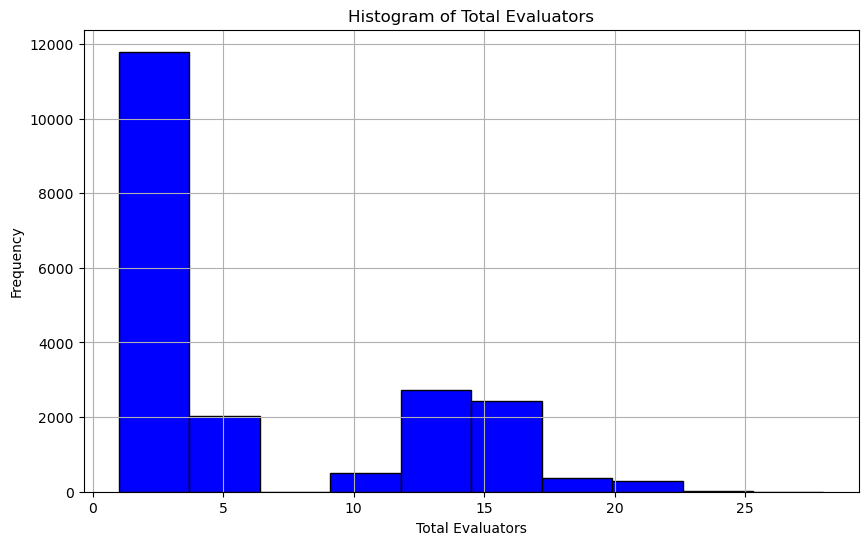

In [10]:
train = train[train['label_id'].isin(all_eegs.keys())].copy()

y_data = train[TARGETS].values # Regularization value
y_data = y_data / y_data.sum(axis=1,keepdims=True)
train[TARGETS] = y_data

train['target'] = train['expert_consensus']

train = train.reset_index(drop=True)

plt.figure(figsize=(10, 6))
plt.hist(train['total_evaluators'], bins=10, color='blue', edgecolor='black')
plt.title('Histogram of Total Evaluators')
plt.xlabel('Total Evaluators')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

del y_data
_ = gc.collect()

# CV Scheme

In [11]:
gkf = GroupKFold(n_splits=CFG.n_fold)

train["fold"] = -1

for fold_id, (_, val_idx) in enumerate(
    gkf.split(train, y=train["target"], groups=train["patient_id"])
):
    train.loc[val_idx, "fold"] = fold_id
    
del gkf
_ = gc.collect()

# Dataset

In [12]:
class CustomDataset(Dataset):
    def __init__(
        self, df: pd.DataFrame,
        augment: bool = False, mode: str = 'train',
        specs: Dict[int, np.ndarray] = spectrograms,
        eeg_specs: Dict[int, np.ndarray] = all_eegs
    ): 
        self.df = df
        self.augment = augment
        self.mode = mode
        self.spectograms = spectrograms
        self.eeg_spectograms = eeg_specs
        
    def __len__(self):
        """
        Denotes the number of batches per epoch.
        """
        return len(self.df)
        
    def __getitem__(self, index):
        """
        Generate one batch of data.
        """
        X, y = self.__data_generation(index)
        if self.augment:
            X = self.__transform(X) 
        return {"spectrogram":torch.tensor(X, dtype=torch.float32), "labels":torch.tensor(y, dtype=torch.float32)}
                        
    def __data_generation(self, index):
        """
        Generates data containing batch_size samples.
        """
        X = np.zeros((128, 256, 8), dtype='float32')
        y = np.zeros(6, dtype='float32')
        img = np.ones((128,256), dtype='float32')
        row = self.df.iloc[index]
        if self.mode=='test': 
            r = 0
        else: 
            r = int(row['spectrogram_label_offset_seconds'] // 2)
            
        for region in range(4):
            img = self.spectograms[row.spectrogram_id][r:r+300, region*100:(region+1)*100].T
            
            # Log transform spectogram
            img = np.clip(img, np.exp(-4), np.exp(8))
            img = np.log(img)

            # Standarize per image
            ep = 1e-6
            mu = np.nanmean(img.flatten())
            std = np.nanstd(img.flatten())
            img = (img-mu)/(std+ep)
            img = np.nan_to_num(img, nan=0.0)
            X[14:-14, :, region] = img[:, 22:-22] / 2.0
            img = self.eeg_spectograms[row.label_id]
            X[:, :, 4:] = img
                
            if self.mode != 'test':
                y = row[TARGETS].values.astype(np.float32)
            
        return X, y
    
    def __transform(self, img):
        params1 = {
                    "num_masks_x": 1,    
                    "mask_x_length": (0, 20), # This line changed from fixed  to a range
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),
                    }
        params2 = {    
                    "num_masks_y": 1,    
                    "mask_y_length": (0, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),    
                    }
        params3 = {    
                    "num_masks_x": (2, 4),
                    "num_masks_y": 5,    
                    "mask_y_length": 8,
                    "mask_x_length": (10, 20),
                    "fill_value": (0, 1, 2, 3, 4, 5, 6, 7),  
                    }
        
        transforms = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.XYMasking(**params1, p=0.3),
            A.XYMasking(**params2, p=0.3),
            A.XYMasking(**params3, p=0.3),
        ])
        return transforms(image=img)['image']

# Dataloader

In [13]:
dataset = CustomDataset(train, augment=True, mode="train")
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

batch = dataset[0]
X, y = batch["spectrogram"], batch["labels"]
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

del dataset, X, y
_ = gc.collect()

X shape: torch.Size([128, 256, 8])
y shape: torch.Size([6])


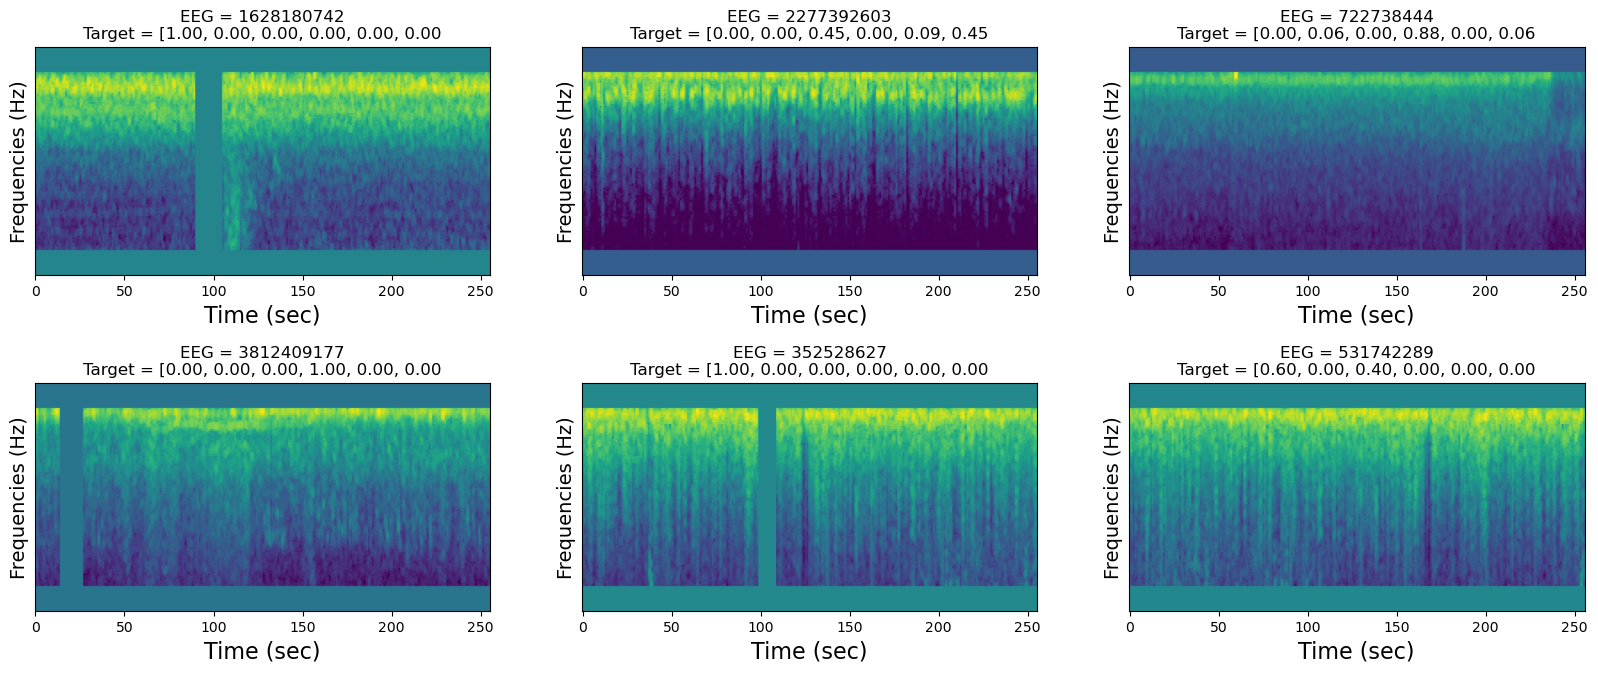

In [14]:
if CFG.VISUALIZE:
    ROWS = 2
    COLS = 3
    for batch in dataloader:
        X, y = batch["spectrogram"], batch["labels"]
        plt.figure(figsize=(20,8))
        for row in range(ROWS):
            for col in range(COLS):
                plt.subplot(ROWS, COLS, row*COLS + col+1)
                t = y[row*COLS + col]
                img = X[row*COLS + col, :, :, 0]
                mn = img.flatten().min()
                mx = img.flatten().max()
                img = (img-mn)/(mx-mn)
                plt.imshow(img)
                tars = f'[{t[0]:0.2f}'
                for s in t[1:]:
                    tars += f', {s:0.2f}'
                eeg = train.eeg_id.values[row*CFG.batch_size + row*COLS + col]
                plt.title(f'EEG = {eeg}\nTarget = {tars}',size=12)
                plt.yticks([])
                plt.ylabel('Frequencies (Hz)',size=14)
                plt.xlabel('Time (sec)',size=16)
        plt.show()
        break
        
del dataloader
_ = gc.collect()

# Model

In [15]:
class CustomModel(nn.Module):
    def __init__(self, config, num_classes: int = 6, pretrained: bool = True):
        super(CustomModel, self).__init__()
        self.USE_KAGGLE_SPECTROGRAMS = True
        self.USE_EEG_SPECTROGRAMS = True
        self.model = timm.create_model(
            config.model_name,
            pretrained=pretrained,
        )
        if CFG.FREEZE:
            total_params = sum(p.numel() for p in self.model.parameters())
            percentage_to_freeze = 0.1
            for i,(name, param) in enumerate(list(self.model.named_parameters())\
                                             [0:int(total_params * percentage_to_freeze)]):
                param.requires_grad = False

        self.features = nn.Sequential(*list(self.model.children())[:-2])
        self.custom_layers = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(self.model.num_features, num_classes)
        )

    def __reshape_input(self, x):
        """
        Reshapes input (128, 256, 8) -> (512, 512, 3) monotone image.
        """ 
        # === Get spectograms ===
        spectograms = [x[:, :, :, i:i+1] for i in range(4)]
        spectograms = torch.cat(spectograms, dim=1)
        
        # === Get EEG spectograms ===
        eegs = [x[:, :, :, i:i+1] for i in range(4,8)]
        eegs = torch.cat(eegs, dim=1)
        
        # === Reshape (512,512,3) ===
        if self.USE_KAGGLE_SPECTROGRAMS & self.USE_EEG_SPECTROGRAMS:
            x = torch.cat([spectograms, eegs], dim=2)
        elif self.USE_EEG_SPECTROGRAMS:
            x = eegs
        else:
            x = spectograms
            
        x = torch.cat([x,x,x], dim=3)
        x = x.permute(0, 3, 1, 2)
        return x
    def extract_features(self, x):
        x = self.__reshape_input(x)
        x = self.features(x)
        return x
    
    def forward(self, x):
        x = self.extract_features(x)
        x = self.custom_layers(x)
        return x

In [16]:
iot = torch.randn(2, 128, 256, 8)
model = CustomModel(CFG)
output = model(iot)
print(output.shape)

del iot, model, output
gc.collect()
torch.cuda.empty_cache()

torch.Size([2, 6])


# Mixup Augmentation

In [17]:
def mixup_data(
        X: torch.Tensor, y: torch.Tensor, config, device,
        alpha: float = 1.0
    ):
    """
    Performs MixUp augmentation.
    :param config: configuration class with param to use mixup or not.
    :param X: batch with images.
    :param y: ground truth.
    :param alpha: parameter to use in the beta distribution.
    :param device: indicates if using CPU or GPU.
    :return mixed_X: mixed X.
    :return y_a: class of the original image.
    :return y_b: class of the image used for mixing.
    :return lambda: lamdba parameter that indicates the percentage of the mix.
    """
    if not config.USE_MIXUP:
        return X, y, None, None
    
    if alpha > 0:
        lam = np.random.beta(alpha, alpha) # draw random number from beta distribution
    else:
        lam = 1

    batch_size = X.size()[0]
    index = torch.randperm(batch_size).to(device) # torch tensor with shuffled numbers between 1:batch_size
    mixed_X = lam * X + (1 - lam) * X[index, :] # perform mixup to the whole batch
    y_a, y_b = y, y[index]
    return mixed_X, y_a, y_b, lam


def get_criterion(config, criterion):
    """
    This function computes the criterion/loss depending whether MixUp augmentation was applied or not.
    If MixUp was applied it returns a weighted average of the loss averaging by the lambda parameter.
    Otherwise, it returns the regular loss as MixUp was not applied.
    :param config: configuration class with param to use mixup or not.
    :param criterion: loss function to use.
    """

    def mixup_criterion(pred, y_a, y_b, lam):
        return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

    def single_criterion(pred, y_a, y_b, lam):
        return criterion(pred, y_a)
    
    if config.USE_MIXUP:
        return mixup_criterion
    else:
        return single_criterion


# Adan Optimizer

In [18]:
import math
import torch
from torch.optim.optimizer import Optimizer


class Adan(Optimizer):
    """
    Implements a pytorch variant of Adan
    Adan was proposed in
    Adan: Adaptive Nesterov Momentum Algorithm for Faster Optimizing Deep Models[J]. arXiv preprint arXiv:2208.06677, 2022.
    https://arxiv.org/abs/2208.06677
    Arguments:
        params (iterable): iterable of parameters to optimize or dicts defining parameter groups.
        lr (float, optional): learning rate. (default: 1e-3)
        betas (Tuple[float, float, flot], optional): coefficients used for computing 
            running averages of gradient and its norm. (default: (0.98, 0.92, 0.99))
        eps (float, optional): term added to the denominator to improve 
            numerical stability. (default: 1e-8)
        weight_decay (float, optional): decoupled weight decay (L2 penalty) (default: 0)
        max_grad_norm (float, optional): value used to clip 
            global grad norm (default: 0.0 no clip)
        no_prox (bool): how to perform the decoupled weight decay (default: False)
    """

    def __init__(self, params, lr=1e-3, betas=(0.98, 0.92, 0.99), eps=1e-8,
                 weight_decay=0.2, max_grad_norm=0.0, no_prox=False):
        if not 0.0 <= max_grad_norm:
            raise ValueError("Invalid Max grad norm: {}".format(max_grad_norm))
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= betas[2] < 1.0:
            raise ValueError("Invalid beta parameter at index 2: {}".format(betas[2]))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay,
                        max_grad_norm=max_grad_norm, no_prox=no_prox)
        super(Adan, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adan, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('no_prox', False)

    @torch.no_grad()
    def restart_opt(self):
        for group in self.param_groups:
            group['step'] = 0
            for p in group['params']:
                if p.requires_grad:
                    state = self.state[p]
                    # State initialization

                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    # Exponential moving average of gradient difference
                    state['exp_avg_diff'] = torch.zeros_like(p)

    @torch.no_grad()
    def step(self):
        """
            Performs a single optimization step.
        """
        if self.defaults['max_grad_norm'] > 0:
            device = self.param_groups[0]['params'][0].device
            global_grad_norm = torch.zeros(1, device=device)

            max_grad_norm = torch.tensor(self.defaults['max_grad_norm'], device=device)
            for group in self.param_groups:

                for p in group['params']:
                    if p.grad is not None:
                        grad = p.grad
                        global_grad_norm.add_(grad.pow(2).sum())

            global_grad_norm = torch.sqrt(global_grad_norm)

            clip_global_grad_norm = torch.clamp(max_grad_norm / (global_grad_norm + group['eps']), max=1.0)
        else:
            clip_global_grad_norm = 1.0

        for group in self.param_groups:
            beta1, beta2, beta3 = group['betas']
            # assume same step across group now to simplify things
            # per parameter step can be easily support by making it tensor, or pass list into kernel
            if 'step' in group:
                group['step'] += 1
            else:
                group['step'] = 1

            bias_correction1 = 1.0 - beta1 ** group['step']

            bias_correction2 = 1.0 - beta2 ** group['step']

            bias_correction3 = 1.0 - beta3 ** group['step']

            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]
                if len(state) == 0:
                    state['exp_avg'] = torch.zeros_like(p)
                    state['exp_avg_sq'] = torch.zeros_like(p)
                    state['exp_avg_diff'] = torch.zeros_like(p)

                grad = p.grad.mul_(clip_global_grad_norm)
                if 'pre_grad' not in state or group['step'] == 1:
                    state['pre_grad'] = grad

                copy_grad = grad.clone()

                exp_avg, exp_avg_sq, exp_avg_diff = state['exp_avg'], state['exp_avg_sq'], state['exp_avg_diff']
                diff = grad - state['pre_grad']

                update = grad + beta2 * diff
                exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)  # m_t
                exp_avg_diff.mul_(beta2).add_(diff, alpha=1 - beta2)  # diff_t
                exp_avg_sq.mul_(beta3).addcmul_(update, update, value=1 - beta3)  # n_t

                denom = ((exp_avg_sq).sqrt() / math.sqrt(bias_correction3)).add_(group['eps'])
                update = ((exp_avg / bias_correction1 + beta2 * exp_avg_diff / bias_correction2)).div_(denom)

                if group['no_prox']:
                    p.data.mul_(1 - group['lr'] * group['weight_decay'])
                    p.add_(update, alpha=-group['lr'])
                else:
                    p.add_(update, alpha=-group['lr'])
                    p.data.div_(1 + group['lr'] * group['weight_decay'])

                state['pre_grad'] = copy_grad

# Helper functions

In [19]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, batch in enumerate(train_loader):
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        mixed_X, y_a, y_b, lam = mixup_data(spectrogram, labels, CFG, device)
        new_criterion = get_criterion(CFG, criterion)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds= model(mixed_X)
            #loss = criterion(F.log_softmax(y_preds, dim=1), labels)
            loss = new_criterion(F.log_softmax(y_preds, dim=1), y_a, y_b, lam)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, batch in enumerate(valid_loader):
        spectrogram = batch['spectrogram'].to(device)
        labels = batch['labels'].to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(spectrogram)
            loss = criterion(F.log_softmax(y_preds, dim=1), labels)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        preds.append(nn.Softmax(dim=1)(y_preds).to('cpu').numpy())
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

# Train Loop

In [20]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold, directory):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if CFG.stage1_pop1:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds[(folds['fold'] != fold) & (folds['total_evaluators'] >= 10)].reset_index(drop=True)
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds[ CFG.target_cols].values
    
    train_dataset = CustomDataset(train_folds, augment=True, mode="train")
    valid_dataset = CustomDataset(valid_folds, augment=False, mode="train")

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size * 2,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG)
    if CFG.stage2_pop2:
        model_weight = POP_1_DIR + f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth"
        checkpoint = torch.load(model_weight, map_location=device)
        model.load_state_dict(checkpoint["model"])
    # CPMP: wrap the model to use all GPUs
    model.to(device)
    if CFG.t4_gpu:
        model = nn.DataParallel(model)
    
    
    
    def build_optimizer(cfg, model, device):
        lr = cfg.lr
        # lr = default_configs["lr"]
        if cfg.optimizer == "SAM":
            base_optimizer = torch.optim.SGD  # define an optimizer for the "sharpness-aware" update
            optimizer_model = SAM(model.parameters(), base_optimizer, lr=lr, momentum=0.9, weight_decay=cfg.weight_decay, adaptive=True)
        elif cfg.optimizer == "Ranger21":
            optimizer_model = Ranger21(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, 
            num_epochs=cfg.epochs, num_batches_per_epoch=len(train_loader))
        elif cfg.optimizer == "SGD":
            optimizer_model = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=cfg.weight_decay, momentum=0.9)
        elif cfg.optimizer == "Adam":
            optimizer_model = Adam(model.parameters(), lr=lr, weight_decay=CFG.weight_decay)
        elif cfg.optimizer == "Lion":
            optimizer_model = Lion(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
        elif cfg.optimizer == "Adan":
            optimizer_model = Adan(model.parameters(), lr=lr, weight_decay=cfg.weight_decay)
    
        return optimizer_model
    
    optimizer = build_optimizer(CFG, model, device)
    
    # ====================================================
    # scheduler
    # ====================================================
    # ====================================================

    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, **CFG.reduce_params)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, **CFG.cosanneal_params)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, **CFG.cosanneal_res_params)
        elif CFG.scheduler=='OneCycleLR':
            steps_per_epoch=len(train_loader),
            scheduler = OneCycleLR(optimizer=optimizer, epochs=CFG.epochs, anneal_strategy="cos", pct_start=0.05, steps_per_epoch=len(train_loader),
        max_lr=CFG.lr, final_div_factor=100)
        return scheduler
    
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.KLDivLoss(reduction="batchmean")

    
    best_score = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score > avg_val_loss:
            best_score = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best valid loss: {avg_val_loss:.4f} Model')
            # CPMP: save the original model. It is stored as the module attribute of the DP model.
            if CFG.stage1_pop1:
                state_dict = model.module.state_dict() if CFG.t4_gpu else model.state_dict()
                torch.save({'model': state_dict ,
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth")
            else:
                state_dict = model.module.state_dict() if CFG.t4_gpu else model.state_dict()
                torch.save({'model': state_dict,
                            'predictions': predictions},
                             directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth")
                
    if CFG.stage1_pop1:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage1.pth", 
                             map_location=torch.device('cpu'))['predictions']
    else:
        predictions = torch.load(directory+f"{CFG.model_name}_fold{fold}_best_version{VERSION}_stage2.pth", 
                             map_location=torch.device('cpu'))['predictions']
    valid_folds[[f"pred_{c}" for c in CFG.target_cols]] = predictions
    valid_folds[CFG.target_cols] = valid_labels 
    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds, best_score

In [21]:
if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_1_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage1: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage1: {np.mean(scores)}')
        oof_df.to_csv(POP_1_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage1.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/504] Elapsed 0m 0s (remain 7m 6s) Loss: 1.4067(1.4067) Grad: 75902.0000  LR: 0.00004015  
Epoch: [1][50/504] Elapsed 0m 6s (remain 0m 54s) Loss: 1.2087(1.3586) Grad: 103407.4141  LR: 0.00038319  
Epoch: [1][100/504] Elapsed 0m 11s (remain 0m 45s) Loss: 1.0974(1.2756) Grad: 91694.5391  LR: 0.00091530  
Epoch: [1][150/504] Elapsed 0m 16s (remain 0m 38s) Loss: 1.2139(1.2171) Grad: 83116.6328  LR: 0.00099971  
Epoch: [1][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8961(1.1765) Grad: 90153.8281  LR: 0.00099752  
Epoch: [1][250/504] Elapsed 0m 27s (remain 0m 27s) Loss: 1.1027(1.1516) Grad: 93448.7812  LR: 0.00099318  
Epoch: [1][300/504] Elapsed 0m 32s (remain 0m 21s) Loss: 0.7307(1.1258) Grad: 82163.7812  LR: 0.00098673  
Epoch: [1][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.1807(1.1085) Grad: 108593.0234  LR: 0.00097818  
Epoch: [1][400/504] Elapsed 0m 42s (remain 0m 11s) Loss: 0.9120(1.0880) Grad: 88830.0547  LR: 0.00096757  
Epoch: [1][450/504] Elapsed 0m 48s (remai

Epoch 1 - avg_train_loss: 1.0638  avg_val_loss: 0.7680  time: 62s
Epoch 1 - Save Best valid loss: 0.7680 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.3029(0.7680) 
Epoch: [2][0/504] Elapsed 0m 0s (remain 1m 58s) Loss: 1.1240(1.1240) Grad: 82003.5156  LR: 0.00093914  
Epoch: [2][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 1.1004(0.9416) Grad: 68811.1953  LR: 0.00092252  
Epoch: [2][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 1.1876(0.9445) Grad: 69578.8906  LR: 0.00090408  
Epoch: [2][150/504] Elapsed 0m 15s (remain 0m 37s) Loss: 0.8217(0.9394) Grad: 71461.2500  LR: 0.00088391  
Epoch: [2][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8170(0.9283) Grad: 69251.7500  LR: 0.00086209  
Epoch: [2][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.1372(0.9314) Grad: 76615.4766  LR: 0.00083871  
Epoch: [2][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.9289(0.9200) Grad: 56684.4609  LR: 0.00081387  
Epoch: [2][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.5910(0.9129) Grad: 61036.0547  LR: 0.00078768  
Epoch: [2][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.1720(0.9124) Grad: 82041.

Epoch 2 - avg_train_loss: 0.9058  avg_val_loss: 0.7324  time: 62s
Epoch 2 - Save Best valid loss: 0.7324 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.2125(0.7324) 
Epoch: [3][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 1.0479(1.0479) Grad: 66442.5234  LR: 0.00069977  
Epoch: [3][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 1.1527(0.8690) Grad: 61261.0000  LR: 0.00066929  
Epoch: [3][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.0524(0.8705) Grad: 65006.8477  LR: 0.00063809  
Epoch: [3][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.9204(0.8652) Grad: 63677.3945  LR: 0.00060629  
Epoch: [3][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9759(0.8739) Grad: 62221.5430  LR: 0.00057404  
Epoch: [3][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.8726(0.8687) Grad: 30759.1992  LR: 0.00054147  
Epoch: [3][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8830(0.8626) Grad: 25513.6523  LR: 0.00050873  
Epoch: [3][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9925(0.8648) Grad: 35013.2539  LR: 0.00047594  
Epoch: [3][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.0009(0.8635) Grad: 32414.

Epoch 3 - avg_train_loss: 0.8556  avg_val_loss: 0.6661  time: 62s
Epoch 3 - Save Best valid loss: 0.6661 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1941(0.6661) 
Epoch: [4][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.9834(0.9834) Grad: 63321.3164  LR: 0.00037624  
Epoch: [4][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.9287(0.8496) Grad: 58323.7383  LR: 0.00034476  
Epoch: [4][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.6875(0.8384) Grad: 84213.5312  LR: 0.00031395  
Epoch: [4][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.1557(0.8374) Grad: 81327.2109  LR: 0.00028394  
Epoch: [4][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.5646(0.8287) Grad: 61340.7812  LR: 0.00025486  
Epoch: [4][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.9318(0.8204) Grad: 52460.0938  LR: 0.00022684  
Epoch: [4][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.9547(0.8241) Grad: 55862.1289  LR: 0.00019999  
Epoch: [4][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.5861(0.8214) Grad: 53750.3164  LR: 0.00017444  
Epoch: [4][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.6917(0.8218) Grad: 64613.

Epoch 4 - avg_train_loss: 0.8203  avg_val_loss: 0.6578  time: 62s
Epoch 4 - Save Best valid loss: 0.6578 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1857(0.6578) 
Epoch: [5][0/504] Elapsed 0m 0s (remain 1m 59s) Loss: 0.9829(0.9829) Grad: 65070.6758  LR: 0.00010498  
Epoch: [5][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.8993(0.8082) Grad: 32769.6719  LR: 0.00008577  
Epoch: [5][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.9880(0.8047) Grad: 34669.1055  LR: 0.00006835  
Epoch: [5][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.7630(0.8085) Grad: 26891.8613  LR: 0.00005278  
Epoch: [5][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.7119(0.8002) Grad: 43854.0508  LR: 0.00003914  
Epoch: [5][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.4812(0.7947) Grad: 30655.9922  LR: 0.00002748  
Epoch: [5][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.6378(0.7928) Grad: 37259.8594  LR: 0.00001786  
Epoch: [5][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.7554(0.7902) Grad: 30626.7500  LR: 0.00001031  
Epoch: [5][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.2928(0.7940) Grad: 54111.

Epoch 5 - avg_train_loss: 0.7989  avg_val_loss: 0.6524  time: 62s
Epoch 5 - Save Best valid loss: 0.6524 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1916(0.6524) 


========== fold: 0 result ==========
Score with best loss weights stage1: 0.6523951998006775
========== fold: 1 training ==========


Epoch: [1][0/504] Elapsed 0m 0s (remain 2m 59s) Loss: 1.4021(1.4021) Grad: 89072.2031  LR: 0.00004015  
Epoch: [1][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 1.3852(1.3714) Grad: 95534.9141  LR: 0.00038319  
Epoch: [1][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.2726(1.2840) Grad: 114530.5625  LR: 0.00091530  
Epoch: [1][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.0589(1.2255) Grad: 87682.1016  LR: 0.00099971  
Epoch: [1][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 1.0622(1.1829) Grad: 77642.2656  LR: 0.00099752  
Epoch: [1][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0789(1.1587) Grad: 89307.3125  LR: 0.00099318  
Epoch: [1][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 1.2466(1.1406) Grad: 81962.7109  LR: 0.00098673  
Epoch: [1][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.1099(1.1236) Grad: 58714.3789  LR: 0.00097818  
Epoch: [1][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.1068(1.1064) Grad: 63578.4141  LR: 0.00096757  
Epoch: [1][450/504] Elapsed 0m 47s (remai

Epoch 1 - avg_train_loss: 1.0799  avg_val_loss: 0.7969  time: 62s
Epoch 1 - Save Best valid loss: 0.7969 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8445(0.7969) 
Epoch: [2][0/504] Elapsed 0m 0s (remain 1m 55s) Loss: 1.0365(1.0365) Grad: 82442.9219  LR: 0.00093914  
Epoch: [2][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.8613(0.9559) Grad: 59727.0547  LR: 0.00092252  
Epoch: [2][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.8505(0.9562) Grad: 61303.0742  LR: 0.00090408  
Epoch: [2][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.8230(0.9564) Grad: 55801.5859  LR: 0.00088391  
Epoch: [2][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 1.0557(0.9493) Grad: 66147.5312  LR: 0.00086209  
Epoch: [2][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.2020(0.9488) Grad: 75949.2734  LR: 0.00083871  
Epoch: [2][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.9779(0.9417) Grad: 31362.1387  LR: 0.00081387  
Epoch: [2][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.6939(0.9430) Grad: 36280.8398  LR: 0.00078768  
Epoch: [2][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.8647(0.9419) Grad: 25154.

Epoch 2 - avg_train_loss: 0.9400  avg_val_loss: 0.6879  time: 62s
Epoch 2 - Save Best valid loss: 0.6879 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6479(0.6879) 
Epoch: [3][0/504] Elapsed 0m 0s (remain 1m 53s) Loss: 0.9244(0.9244) Grad: 55508.1641  LR: 0.00069977  
Epoch: [3][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.8965(0.9004) Grad: 58839.4570  LR: 0.00066929  
Epoch: [3][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.8388(0.8831) Grad: 50508.2734  LR: 0.00063809  
Epoch: [3][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.7819(0.8826) Grad: 62121.1172  LR: 0.00060629  
Epoch: [3][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.7362(0.8713) Grad: 69029.5312  LR: 0.00057404  
Epoch: [3][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7401(0.8793) Grad: 68683.0000  LR: 0.00054147  
Epoch: [3][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8799(0.8801) Grad: 41581.9961  LR: 0.00050873  
Epoch: [3][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.0934(0.8787) Grad: 33073.8867  LR: 0.00047594  
Epoch: [3][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.9390(0.8742) Grad: 30807.

Epoch 3 - avg_train_loss: 0.8721  avg_val_loss: 0.6559  time: 62s
Epoch 3 - Save Best valid loss: 0.6559 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.4741(0.6559) 
Epoch: [4][0/504] Elapsed 0m 0s (remain 1m 57s) Loss: 0.7551(0.7551) Grad: 63610.0430  LR: 0.00037624  
Epoch: [4][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.6220(0.8520) Grad: 58322.8555  LR: 0.00034476  
Epoch: [4][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.9874(0.8372) Grad: 62483.9180  LR: 0.00031395  
Epoch: [4][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.8542(0.8250) Grad: 48512.0469  LR: 0.00028394  
Epoch: [4][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.7255(0.8287) Grad: 54846.0703  LR: 0.00025486  
Epoch: [4][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.8266(0.8311) Grad: 52508.4844  LR: 0.00022684  
Epoch: [4][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.4933(0.8329) Grad: 59485.2891  LR: 0.00019999  
Epoch: [4][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.7584(0.8401) Grad: 61920.5781  LR: 0.00017444  
Epoch: [4][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.9225(0.8449) Grad: 70220.

Epoch 4 - avg_train_loss: 0.8354  avg_val_loss: 0.6175  time: 62s
Epoch 4 - Save Best valid loss: 0.6175 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.4014(0.6175) 
Epoch: [5][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.8696(0.8696) Grad: 64694.6914  LR: 0.00010498  
Epoch: [5][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.9846(0.8398) Grad: 59370.0547  LR: 0.00008577  
Epoch: [5][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.9142(0.8286) Grad: 66769.5234  LR: 0.00006835  
Epoch: [5][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.5880(0.8196) Grad: 58933.0977  LR: 0.00005278  
Epoch: [5][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9128(0.8181) Grad: 69502.3281  LR: 0.00003914  
Epoch: [5][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7357(0.8177) Grad: 48350.3281  LR: 0.00002748  
Epoch: [5][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 1.1161(0.8226) Grad: 54322.5938  LR: 0.00001786  
Epoch: [5][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.8277(0.8238) Grad: 46950.6836  LR: 0.00001031  
Epoch: [5][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.9521(0.8190) Grad: 30551.

Epoch 5 - avg_train_loss: 0.8175  avg_val_loss: 0.6190  time: 62s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.4452(0.6190) 


========== fold: 1 result ==========
Score with best loss weights stage1: 0.6174548268687291
========== fold: 2 training ==========


Epoch: [1][0/504] Elapsed 0m 0s (remain 3m 12s) Loss: 1.5919(1.5919) Grad: 112701.6016  LR: 0.00004015  
Epoch: [1][50/504] Elapsed 0m 5s (remain 0m 50s) Loss: 1.1850(1.3506) Grad: 92558.9375  LR: 0.00038319  
Epoch: [1][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.1354(1.2663) Grad: 104563.4453  LR: 0.00091530  
Epoch: [1][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.1545(1.2230) Grad: 98547.0938  LR: 0.00099971  
Epoch: [1][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9624(1.1850) Grad: 129145.7266  LR: 0.00099752  
Epoch: [1][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.9051(1.1546) Grad: 71683.8125  LR: 0.00099318  
Epoch: [1][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8528(1.1267) Grad: 67442.0547  LR: 0.00098673  
Epoch: [1][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9862(1.1076) Grad: 107463.5312  LR: 0.00097818  
Epoch: [1][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.0102(1.0919) Grad: 70551.1953  LR: 0.00096757  
Epoch: [1][450/504] Elapsed 0m 47s (re

Epoch 1 - avg_train_loss: 1.0660  avg_val_loss: 0.7675  time: 62s
Epoch 1 - Save Best valid loss: 0.7675 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.9868(0.7675) 
Epoch: [2][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 1.1770(1.1770) Grad: 76085.6484  LR: 0.00093914  
Epoch: [2][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 1.0065(0.9363) Grad: 70486.0938  LR: 0.00092252  
Epoch: [2][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 1.0808(0.9443) Grad: 71659.1094  LR: 0.00090408  
Epoch: [2][150/504] Elapsed 0m 15s (remain 0m 37s) Loss: 0.8350(0.9493) Grad: 62469.2461  LR: 0.00088391  
Epoch: [2][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 1.2599(0.9393) Grad: 112304.0469  LR: 0.00086209  
Epoch: [2][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0584(0.9423) Grad: 75787.2969  LR: 0.00083871  
Epoch: [2][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8090(0.9364) Grad: 73382.6328  LR: 0.00081387  
Epoch: [2][350/504] Elapsed 0m 36s (remain 0m 16s) Loss: 0.8239(0.9359) Grad: 27896.5332  LR: 0.00078768  
Epoch: [2][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.8046(0.9333) Grad: 40262

Epoch 2 - avg_train_loss: 0.9280  avg_val_loss: 0.6698  time: 62s
Epoch 2 - Save Best valid loss: 0.6698 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7678(0.6698) 
Epoch: [3][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.8991(0.8991) Grad: 51359.5117  LR: 0.00069977  
Epoch: [3][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 0.7659(0.8497) Grad: 72667.1562  LR: 0.00066929  
Epoch: [3][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.7447(0.8711) Grad: 50424.4727  LR: 0.00063809  
Epoch: [3][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.7698(0.8825) Grad: 51158.0039  LR: 0.00060629  
Epoch: [3][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9252(0.8772) Grad: 71966.3906  LR: 0.00057404  
Epoch: [3][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7871(0.8736) Grad: 55389.3477  LR: 0.00054147  
Epoch: [3][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.9899(0.8739) Grad: 57910.1094  LR: 0.00050873  
Epoch: [3][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9043(0.8760) Grad: 74385.0469  LR: 0.00047594  
Epoch: [3][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.8210(0.8738) Grad: 42610.

Epoch 3 - avg_train_loss: 0.8730  avg_val_loss: 0.6167  time: 62s
Epoch 3 - Save Best valid loss: 0.6167 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7222(0.6167) 
Epoch: [4][0/504] Elapsed 0m 0s (remain 1m 58s) Loss: 0.9986(0.9986) Grad: 87530.3047  LR: 0.00037624  
Epoch: [4][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.9202(0.8260) Grad: 64753.5234  LR: 0.00034476  
Epoch: [4][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.9741(0.8357) Grad: 60949.1641  LR: 0.00031395  
Epoch: [4][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.8372(0.8386) Grad: 50726.2812  LR: 0.00028394  
Epoch: [4][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.5802(0.8366) Grad: 68818.1406  LR: 0.00025486  
Epoch: [4][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.9135(0.8393) Grad: 55775.6406  LR: 0.00022684  
Epoch: [4][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.6178(0.8361) Grad: 65140.9961  LR: 0.00019999  
Epoch: [4][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.8385(0.8358) Grad: 50979.6758  LR: 0.00017444  
Epoch: [4][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 1.1220(0.8385) Grad: 69617.

Epoch 4 - avg_train_loss: 0.8350  avg_val_loss: 0.5874  time: 62s
Epoch 4 - Save Best valid loss: 0.5874 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5821(0.5874) 
Epoch: [5][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.4388(0.4388) Grad: 59095.4023  LR: 0.00010498  
Epoch: [5][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.9882(0.8082) Grad: 84710.9766  LR: 0.00008577  
Epoch: [5][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.0107(0.8133) Grad: 62382.9180  LR: 0.00006835  
Epoch: [5][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.8075(0.8230) Grad: 60189.7227  LR: 0.00005278  
Epoch: [5][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9367(0.8205) Grad: 64754.5859  LR: 0.00003914  
Epoch: [5][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0510(0.8095) Grad: 65595.6953  LR: 0.00002748  
Epoch: [5][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 1.0063(0.8159) Grad: 66310.4141  LR: 0.00001786  
Epoch: [5][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.6937(0.8143) Grad: 53969.2773  LR: 0.00001031  
Epoch: [5][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.8574(0.8126) Grad: 63904.

Epoch 5 - avg_train_loss: 0.8122  avg_val_loss: 0.5857  time: 62s
Epoch 5 - Save Best valid loss: 0.5857 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5962(0.5857) 


========== fold: 2 result ==========
Score with best loss weights stage1: 0.5857450671351898
========== fold: 3 training ==========


Epoch: [1][0/504] Elapsed 0m 0s (remain 3m 9s) Loss: 1.4129(1.4129) Grad: 123854.7344  LR: 0.00004015  
Epoch: [1][50/504] Elapsed 0m 5s (remain 0m 50s) Loss: 1.3032(1.3593) Grad: 80148.2500  LR: 0.00038319  
Epoch: [1][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.3624(1.2655) Grad: 115375.1562  LR: 0.00091530  
Epoch: [1][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.1630(1.2183) Grad: 100310.7734  LR: 0.00099971  
Epoch: [1][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.9040(1.1759) Grad: 130103.3906  LR: 0.00099752  
Epoch: [1][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0827(1.1422) Grad: 76638.5938  LR: 0.00099318  
Epoch: [1][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8060(1.1142) Grad: 64376.4570  LR: 0.00098673  
Epoch: [1][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.0856(1.0998) Grad: 84193.5469  LR: 0.00097818  
Epoch: [1][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.9986(1.0833) Grad: 62530.4961  LR: 0.00096757  
Epoch: [1][450/504] Elapsed 0m 47s (rem

Epoch 1 - avg_train_loss: 1.0542  avg_val_loss: 0.8493  time: 62s
Epoch 1 - Save Best valid loss: 0.8493 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 2.5340(0.8493) 
Epoch: [2][0/504] Elapsed 0m 0s (remain 1m 58s) Loss: 0.8813(0.8813) Grad: 67804.7734  LR: 0.00093914  
Epoch: [2][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.7188(0.9008) Grad: 30707.1934  LR: 0.00092252  
Epoch: [2][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.9697(0.9072) Grad: 30144.6621  LR: 0.00090408  
Epoch: [2][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.0184(0.9050) Grad: 33977.6953  LR: 0.00088391  
Epoch: [2][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 1.0622(0.9118) Grad: 30625.0312  LR: 0.00086209  
Epoch: [2][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0154(0.9058) Grad: 42835.3906  LR: 0.00083871  
Epoch: [2][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.7974(0.9114) Grad: 32286.5020  LR: 0.00081387  
Epoch: [2][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.1292(0.9093) Grad: 38655.2930  LR: 0.00078768  
Epoch: [2][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.7200(0.9042) Grad: 36528.

Epoch 2 - avg_train_loss: 0.9079  avg_val_loss: 0.7537  time: 62s
Epoch 2 - Save Best valid loss: 0.7537 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 2.2783(0.7537) 
Epoch: [3][0/504] Elapsed 0m 0s (remain 1m 58s) Loss: 0.8747(0.8747) Grad: 63746.7344  LR: 0.00069977  
Epoch: [3][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 0.7396(0.8362) Grad: 57616.0430  LR: 0.00066929  
Epoch: [3][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.7996(0.8458) Grad: 38096.4961  LR: 0.00063809  
Epoch: [3][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.0023(0.8466) Grad: 30758.3652  LR: 0.00060629  
Epoch: [3][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8642(0.8473) Grad: 28725.3223  LR: 0.00057404  
Epoch: [3][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.9824(0.8588) Grad: 16841.7188  LR: 0.00054147  
Epoch: [3][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.9300(0.8548) Grad: 14080.8174  LR: 0.00050873  
Epoch: [3][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9144(0.8569) Grad: 12717.5586  LR: 0.00047594  
Epoch: [3][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.9538(0.8588) Grad: 14630.

Epoch 3 - avg_train_loss: 0.8532  avg_val_loss: 0.7118  time: 62s
Epoch 3 - Save Best valid loss: 0.7118 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.6830(0.7118) 
Epoch: [4][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.6335(0.6335) Grad: 53237.7227  LR: 0.00037624  
Epoch: [4][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 0.6314(0.8329) Grad: 58978.4688  LR: 0.00034476  
Epoch: [4][100/504] Elapsed 0m 10s (remain 0m 42s) Loss: 0.8205(0.8321) Grad: 60587.1250  LR: 0.00031395  
Epoch: [4][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.9736(0.8365) Grad: 56417.6055  LR: 0.00028394  
Epoch: [4][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8375(0.8227) Grad: 51298.2148  LR: 0.00025486  
Epoch: [4][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7132(0.8231) Grad: 64594.6602  LR: 0.00022684  
Epoch: [4][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.7803(0.8165) Grad: 57540.8633  LR: 0.00019999  
Epoch: [4][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9835(0.8225) Grad: 72494.5469  LR: 0.00017444  
Epoch: [4][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.5626(0.8225) Grad: 51100.

Epoch 4 - avg_train_loss: 0.8231  avg_val_loss: 0.6864  time: 62s
Epoch 4 - Save Best valid loss: 0.6864 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.8244(0.6864) 
Epoch: [5][0/504] Elapsed 0m 0s (remain 2m 9s) Loss: 0.6904(0.6904) Grad: 57230.8398  LR: 0.00010498  
Epoch: [5][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 0.9855(0.8609) Grad: 52826.2188  LR: 0.00008577  
Epoch: [5][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.6752(0.8420) Grad: 30673.1309  LR: 0.00006835  
Epoch: [5][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.7480(0.8292) Grad: 36524.7305  LR: 0.00005278  
Epoch: [5][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8615(0.8178) Grad: 28232.9492  LR: 0.00003914  
Epoch: [5][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0006(0.8215) Grad: 29927.6016  LR: 0.00002748  
Epoch: [5][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.7433(0.8218) Grad: 31764.6016  LR: 0.00001786  
Epoch: [5][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.7445(0.8262) Grad: 27320.2168  LR: 0.00001031  
Epoch: [5][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.5186(0.8259) Grad: 28913.4

Epoch 5 - avg_train_loss: 0.8184  avg_val_loss: 0.6530  time: 62s
Epoch 5 - Save Best valid loss: 0.6530 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.5342(0.6530) 


========== fold: 3 result ==========
Score with best loss weights stage1: 0.652971776200475
========== fold: 4 training ==========


Epoch: [1][0/504] Elapsed 0m 0s (remain 3m 1s) Loss: 1.5103(1.5103) Grad: 77860.1641  LR: 0.00004015  
Epoch: [1][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 1.3608(1.3788) Grad: 80651.9219  LR: 0.00038319  
Epoch: [1][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 1.0569(1.2809) Grad: 100905.0156  LR: 0.00091530  
Epoch: [1][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.0121(1.2242) Grad: 95871.8438  LR: 0.00099971  
Epoch: [1][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 1.0756(1.1869) Grad: 72487.5391  LR: 0.00099752  
Epoch: [1][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7729(1.1515) Grad: 87986.8594  LR: 0.00099318  
Epoch: [1][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 1.0291(1.1304) Grad: 74241.6016  LR: 0.00098673  
Epoch: [1][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.8077(1.1108) Grad: 81576.1562  LR: 0.00097818  
Epoch: [1][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.7386(1.0948) Grad: 59248.1797  LR: 0.00096757  
Epoch: [1][450/504] Elapsed 0m 47s (remain

Epoch 1 - avg_train_loss: 1.0668  avg_val_loss: 0.8342  time: 62s
Epoch 1 - Save Best valid loss: 0.8342 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8697(0.8342) 
Epoch: [2][0/504] Elapsed 0m 0s (remain 1m 59s) Loss: 0.9732(0.9732) Grad: 57544.5625  LR: 0.00093914  
Epoch: [2][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 1.0946(0.9070) Grad: 93753.3125  LR: 0.00092252  
Epoch: [2][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.9932(0.9263) Grad: 61411.1445  LR: 0.00090408  
Epoch: [2][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 1.0947(0.9158) Grad: 84172.8125  LR: 0.00088391  
Epoch: [2][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8837(0.9210) Grad: 49919.0781  LR: 0.00086209  
Epoch: [2][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.8465(0.9169) Grad: 63790.9219  LR: 0.00083871  
Epoch: [2][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8696(0.9132) Grad: 63051.5781  LR: 0.00081387  
Epoch: [2][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.7180(0.9126) Grad: 85977.5234  LR: 0.00078768  
Epoch: [2][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.7434(0.9113) Grad: 55028.

Epoch 2 - avg_train_loss: 0.9075  avg_val_loss: 0.7500  time: 62s
Epoch 2 - Save Best valid loss: 0.7500 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6562(0.7500) 
Epoch: [3][0/504] Elapsed 0m 0s (remain 1m 58s) Loss: 0.8973(0.8973) Grad: 51560.5938  LR: 0.00069977  
Epoch: [3][50/504] Elapsed 0m 5s (remain 0m 48s) Loss: 1.0726(0.8509) Grad: 64524.7891  LR: 0.00066929  
Epoch: [3][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.6671(0.8521) Grad: 85481.7422  LR: 0.00063809  
Epoch: [3][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.7208(0.8462) Grad: 68457.1094  LR: 0.00060629  
Epoch: [3][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.5826(0.8565) Grad: 72676.6250  LR: 0.00057404  
Epoch: [3][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 1.0222(0.8599) Grad: 82511.3281  LR: 0.00054147  
Epoch: [3][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.7170(0.8659) Grad: 83734.4609  LR: 0.00050873  
Epoch: [3][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.9986(0.8680) Grad: 62797.3516  LR: 0.00047594  
Epoch: [3][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.6796(0.8645) Grad: 66788.

Epoch 3 - avg_train_loss: 0.8651  avg_val_loss: 0.7131  time: 62s
Epoch 3 - Save Best valid loss: 0.7131 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8007(0.7131) 
Epoch: [4][0/504] Elapsed 0m 0s (remain 2m 0s) Loss: 0.9660(0.9660) Grad: 58119.7852  LR: 0.00037624  
Epoch: [4][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 0.9719(0.8629) Grad: 63710.9258  LR: 0.00034476  
Epoch: [4][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.8822(0.8525) Grad: 64217.1797  LR: 0.00031395  
Epoch: [4][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.8562(0.8259) Grad: 75203.3984  LR: 0.00028394  
Epoch: [4][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.6959(0.8248) Grad: 56253.9062  LR: 0.00025486  
Epoch: [4][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.6990(0.8208) Grad: 56806.8789  LR: 0.00022684  
Epoch: [4][300/504] Elapsed 0m 32s (remain 0m 21s) Loss: 1.0017(0.8210) Grad: 70361.9375  LR: 0.00019999  
Epoch: [4][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 1.0280(0.8235) Grad: 71737.5781  LR: 0.00017444  
Epoch: [4][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.8814(0.8226) Grad: 64699.9

Epoch 4 - avg_train_loss: 0.8257  avg_val_loss: 0.6960  time: 62s
Epoch 4 - Save Best valid loss: 0.6960 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8424(0.6960) 
Epoch: [5][0/504] Elapsed 0m 0s (remain 1m 56s) Loss: 0.5846(0.5846) Grad: 45957.1797  LR: 0.00010498  
Epoch: [5][50/504] Elapsed 0m 5s (remain 0m 49s) Loss: 0.9366(0.8129) Grad: 72991.5391  LR: 0.00008577  
Epoch: [5][100/504] Elapsed 0m 10s (remain 0m 43s) Loss: 0.7963(0.8131) Grad: 55548.2031  LR: 0.00006835  
Epoch: [5][150/504] Elapsed 0m 16s (remain 0m 37s) Loss: 0.5151(0.8084) Grad: 53909.1406  LR: 0.00005278  
Epoch: [5][200/504] Elapsed 0m 21s (remain 0m 32s) Loss: 0.8884(0.8079) Grad: 61414.1914  LR: 0.00003914  
Epoch: [5][250/504] Elapsed 0m 26s (remain 0m 26s) Loss: 0.7165(0.8052) Grad: 56986.5391  LR: 0.00002748  
Epoch: [5][300/504] Elapsed 0m 31s (remain 0m 21s) Loss: 0.8038(0.8065) Grad: 48103.3984  LR: 0.00001786  
Epoch: [5][350/504] Elapsed 0m 37s (remain 0m 16s) Loss: 0.6180(0.8130) Grad: 59984.7695  LR: 0.00001031  
Epoch: [5][400/504] Elapsed 0m 42s (remain 0m 10s) Loss: 0.6387(0.8136) Grad: 54893.

Epoch 5 - avg_train_loss: 0.8153  avg_val_loss: 0.6808  time: 62s
Epoch 5 - Save Best valid loss: 0.6808 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8267(0.6808) 


========== fold: 4 result ==========
Score with best loss weights stage1: 0.6807960388799843
========== CV ==========
Score with best loss weights stage1: 0.6378725817770112


In [22]:
CFG.stage1_pop1 = False
CFG.stage2_pop2 = True
CFG.epochs = 5

if __name__ == '__main__':
    
    if CFG.train:
        oof_df = pd.DataFrame()
        scores = []
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df, score = train_loop(train, fold, POP_2_DIR)
                oof_df = pd.concat([oof_df, _oof_df])
                scores.append(score)
                LOGGER.info(f"========== fold: {fold} result ==========")
                LOGGER.info(f'Score with best loss weights stage2: {score}')
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        LOGGER.info(f'Score with best loss weights stage2: {np.mean(scores)}')
        oof_df.to_csv(POP_2_DIR+f'{CFG.model_name}_oof_df_version{VERSION}_stage2.csv', index=False)
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========


Epoch: [1][0/155] Elapsed 0m 0s (remain 0m 54s) Loss: 0.7826(0.7826) Grad: 61505.8203  LR: 0.00004166  
Epoch: [1][50/155] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4961(0.5856) Grad: 42233.6133  LR: 0.00099920  
Epoch: [1][100/155] Elapsed 0m 10s (remain 0m 5s) Loss: 0.6321(0.5811) Grad: 32715.7051  LR: 0.00098191  
Epoch: [1][150/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4420(0.5702) Grad: 30244.4199  LR: 0.00094277  
Epoch: [1][154/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4270(0.5708) Grad: 38652.5586  LR: 0.00093874  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 23s) Loss: 0.7540(0.7540) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.9624(0.8275) 


Epoch 1 - avg_train_loss: 0.5708  avg_val_loss: 0.8136  time: 25s
Epoch 1 - Save Best valid loss: 0.8136 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1921(0.8136) 
Epoch: [2][0/155] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4693(0.4693) Grad: 34641.0977  LR: 0.00093771  
Epoch: [2][50/155] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4467(0.5361) Grad: 35800.5898  LR: 0.00087664  
Epoch: [2][100/155] Elapsed 0m 10s (remain 0m 5s) Loss: 0.6261(0.5423) Grad: 40731.1328  LR: 0.00079849  
Epoch: [2][150/155] Elapsed 0m 15s (remain 0m 0s) Loss: 0.7028(0.5445) Grad: 44216.8125  LR: 0.00070681  
Epoch: [2][154/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4375(0.5435) Grad: 50178.2148  LR: 0.00069901  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7247(0.7247) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.9099(0.7697) 


Epoch 2 - avg_train_loss: 0.5435  avg_val_loss: 0.7596  time: 25s
Epoch 2 - Save Best valid loss: 0.7596 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1684(0.7596) 
Epoch: [3][0/155] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5945(0.5945) Grad: 41306.8047  LR: 0.00069705  
Epoch: [3][50/155] Elapsed 0m 5s (remain 0m 11s) Loss: 0.3753(0.5235) Grad: 39681.1484  LR: 0.00059532  
Epoch: [3][100/155] Elapsed 0m 10s (remain 0m 5s) Loss: 0.4758(0.5187) Grad: 36268.3750  LR: 0.00048927  
Epoch: [3][150/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5109(0.5152) Grad: 44592.2969  LR: 0.00038372  
Epoch: [3][154/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5618(0.5173) Grad: 32900.6289  LR: 0.00037544  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7126(0.7126) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.9815(0.7987) 


Epoch 3 - avg_train_loss: 0.5173  avg_val_loss: 0.7859  time: 25s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1563(0.7859) 
Epoch: [4][0/155] Elapsed 0m 0s (remain 0m 35s) Loss: 0.3438(0.3438) Grad: 33481.5508  LR: 0.00037338  
Epoch: [4][50/155] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4554(0.4791) Grad: 33336.1406  LR: 0.00027389  
Epoch: [4][100/155] Elapsed 0m 10s (remain 0m 5s) Loss: 0.4816(0.4858) Grad: 31676.8301  LR: 0.00018467  
Epoch: [4][150/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6610(0.4896) Grad: 38741.8750  LR: 0.00010975  
Epoch: [4][154/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5153(0.4889) Grad: 37914.5703  LR: 0.00010448  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6948(0.6948) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.9591(0.7668) 


Epoch 4 - avg_train_loss: 0.4889  avg_val_loss: 0.7563  time: 25s
Epoch 4 - Save Best valid loss: 0.7563 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1638(0.7563) 
Epoch: [5][0/155] Elapsed 0m 0s (remain 0m 36s) Loss: 0.3844(0.3844) Grad: 39956.4570  LR: 0.00010318  
Epoch: [5][50/155] Elapsed 0m 5s (remain 0m 11s) Loss: 0.6424(0.4978) Grad: 35350.6367  LR: 0.00004790  
Epoch: [5][100/155] Elapsed 0m 10s (remain 0m 5s) Loss: 0.7061(0.5025) Grad: 57060.9414  LR: 0.00001313  
Epoch: [5][150/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5480(0.4975) Grad: 40721.4883  LR: 0.00000044  
Epoch: [5][154/155] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3567(0.4963) Grad: 36617.7734  LR: 0.00000040  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7026(0.7026) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.9673(0.7757) 


Epoch 5 - avg_train_loss: 0.4963  avg_val_loss: 0.7649  time: 25s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1576(0.7649) 


========== fold: 0 result ==========
Score with best loss weights stage2: 0.7562932212857111
========== fold: 1 training ==========


Epoch: [1][0/158] Elapsed 0m 0s (remain 0m 54s) Loss: 0.6546(0.6546) Grad: 77587.2344  LR: 0.00004160  
Epoch: [1][50/158] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4183(0.5825) Grad: 49145.7695  LR: 0.00099932  
Epoch: [1][100/158] Elapsed 0m 10s (remain 0m 6s) Loss: 0.5498(0.5710) Grad: 64356.8555  LR: 0.00098299  
Epoch: [1][150/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6278(0.5654) Grad: 46337.8125  LR: 0.00094560  
Epoch: [1][157/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5221(0.5628) Grad: 37035.1992  LR: 0.00093876  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 23s) Loss: 0.6844(0.6844) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.7032(0.7953) 


Epoch 1 - avg_train_loss: 0.5628  avg_val_loss: 0.8087  time: 26s
Epoch 1 - Save Best valid loss: 0.8087 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0552(0.8087) 
Epoch: [2][0/158] Elapsed 0m 0s (remain 0m 37s) Loss: 0.8212(0.8212) Grad: 49171.5039  LR: 0.00093775  
Epoch: [2][50/158] Elapsed 0m 5s (remain 0m 11s) Loss: 0.3359(0.5461) Grad: 46225.4922  LR: 0.00087802  
Epoch: [2][100/158] Elapsed 0m 10s (remain 0m 6s) Loss: 0.4559(0.5503) Grad: 51092.5000  LR: 0.00080179  
Epoch: [2][150/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5541(0.5414) Grad: 33740.2695  LR: 0.00071240  
Epoch: [2][157/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.7037(0.5434) Grad: 35983.7422  LR: 0.00069905  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6161(0.6161) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.7024(0.7288) 


Epoch 2 - avg_train_loss: 0.5434  avg_val_loss: 0.7331  time: 25s
Epoch 2 - Save Best valid loss: 0.7331 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8393(0.7331) 
Epoch: [3][0/158] Elapsed 0m 0s (remain 0m 36s) Loss: 0.4254(0.4254) Grad: 41568.7383  LR: 0.00069713  
Epoch: [3][50/158] Elapsed 0m 5s (remain 0m 11s) Loss: 0.3344(0.5362) Grad: 41301.1562  LR: 0.00059739  
Epoch: [3][100/158] Elapsed 0m 10s (remain 0m 6s) Loss: 0.5632(0.5310) Grad: 33167.1836  LR: 0.00049340  
Epoch: [3][150/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6776(0.5331) Grad: 43794.5312  LR: 0.00038971  
Epoch: [3][157/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4515(0.5339) Grad: 44564.3359  LR: 0.00037548  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6189(0.6189) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.7051(0.7383) 


Epoch 3 - avg_train_loss: 0.5339  avg_val_loss: 0.7509  time: 25s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7337(0.7509) 
Epoch: [4][0/158] Elapsed 0m 0s (remain 0m 35s) Loss: 0.4004(0.4004) Grad: 47912.2305  LR: 0.00037345  
Epoch: [4][50/158] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5091(0.5180) Grad: 34890.0664  LR: 0.00027577  
Epoch: [4][100/158] Elapsed 0m 10s (remain 0m 6s) Loss: 0.4693(0.5112) Grad: 37150.6289  LR: 0.00018788  
Epoch: [4][150/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.7296(0.5130) Grad: 44949.6055  LR: 0.00011362  
Epoch: [4][157/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6091(0.5138) Grad: 39638.9023  LR: 0.00010451  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.5777(0.5777) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.6693(0.7064) 


Epoch 4 - avg_train_loss: 0.5138  avg_val_loss: 0.7169  time: 25s
Epoch 4 - Save Best valid loss: 0.7169 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6972(0.7169) 
Epoch: [5][0/158] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5674(0.5674) Grad: 29531.6406  LR: 0.00010323  
Epoch: [5][50/158] Elapsed 0m 5s (remain 0m 11s) Loss: 0.3826(0.5221) Grad: 39798.1992  LR: 0.00004880  
Epoch: [5][100/158] Elapsed 0m 10s (remain 0m 6s) Loss: 0.6267(0.5123) Grad: 33708.8672  LR: 0.00001407  
Epoch: [5][150/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5779(0.5072) Grad: 42144.0352  LR: 0.00000056  
Epoch: [5][157/158] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4866(0.5045) Grad: 34639.6758  LR: 0.00000040  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.5852(0.5852) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6770(0.7110) 


Epoch 5 - avg_train_loss: 0.5045  avg_val_loss: 0.7218  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6670(0.7218) 


========== fold: 1 result ==========
Score with best loss weights stage2: 0.7168788505214732
========== fold: 2 training ==========


Epoch: [1][0/160] Elapsed 0m 0s (remain 0m 56s) Loss: 0.6761(0.6761) Grad: 66928.6562  LR: 0.00004156  
Epoch: [1][50/160] Elapsed 0m 5s (remain 0m 12s) Loss: 0.5940(0.5664) Grad: 39095.3867  LR: 0.00099939  
Epoch: [1][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.6990(0.5555) Grad: 52556.7422  LR: 0.00098368  
Epoch: [1][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5907(0.5657) Grad: 60815.4727  LR: 0.00094739  
Epoch: [1][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.6090(0.5659) Grad: 45702.7969  LR: 0.00093877  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 23s) Loss: 0.6735(0.6735) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.8907(0.8393) 


Epoch 1 - avg_train_loss: 0.5659  avg_val_loss: 0.8461  time: 26s
Epoch 1 - Save Best valid loss: 0.8461 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5174(0.8461) 
Epoch: [2][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5431(0.5431) Grad: 29943.5254  LR: 0.00093778  
Epoch: [2][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5611(0.5221) Grad: 33555.9922  LR: 0.00087891  
Epoch: [2][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.7372(0.5309) Grad: 48173.1914  LR: 0.00080391  
Epoch: [2][150/160] Elapsed 0m 15s (remain 0m 0s) Loss: 0.4341(0.5365) Grad: 35855.4180  LR: 0.00071599  
Epoch: [2][159/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6538(0.5356) Grad: 37712.3320  LR: 0.00069907  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6279(0.6279) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.8025(0.7496) 


Epoch 2 - avg_train_loss: 0.5356  avg_val_loss: 0.7623  time: 26s
Epoch 2 - Save Best valid loss: 0.7623 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7243(0.7623) 
Epoch: [3][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5168(0.5168) Grad: 32368.0410  LR: 0.00069718  
Epoch: [3][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.6664(0.5345) Grad: 54359.5195  LR: 0.00059872  
Epoch: [3][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.2770(0.5296) Grad: 39534.1094  LR: 0.00049607  
Epoch: [3][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.6117(0.5178) Grad: 45439.1094  LR: 0.00039359  
Epoch: [3][159/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.7091(0.5218) Grad: 56624.1172  LR: 0.00037550  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6284(0.6284) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.7481(0.7090) 


Epoch 3 - avg_train_loss: 0.5218  avg_val_loss: 0.7149  time: 26s
Epoch 3 - Save Best valid loss: 0.7149 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5592(0.7149) 
Epoch: [4][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4098(0.4098) Grad: 34594.5977  LR: 0.00037351  
Epoch: [4][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.6600(0.5102) Grad: 36859.1133  LR: 0.00027698  
Epoch: [4][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.5034(0.5105) Grad: 30837.9609  LR: 0.00018997  
Epoch: [4][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4403(0.4961) Grad: 32157.2520  LR: 0.00011615  
Epoch: [4][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.3184(0.4972) Grad: 34512.1992  LR: 0.00010452  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6147(0.6147) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.7594(0.7128) 


Epoch 4 - avg_train_loss: 0.4972  avg_val_loss: 0.7217  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5726(0.7217) 
Epoch: [5][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5378(0.5378) Grad: 34345.2227  LR: 0.00010326  
Epoch: [5][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.7041(0.5193) Grad: 39902.2344  LR: 0.00004938  
Epoch: [5][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.5423(0.5046) Grad: 35096.2930  LR: 0.00001470  
Epoch: [5][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3495(0.5012) Grad: 50593.6758  LR: 0.00000067  
Epoch: [5][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.4644(0.5006) Grad: 42074.1445  LR: 0.00000040  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.6108(0.6108) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.7615(0.7075) 


Epoch 5 - avg_train_loss: 0.5006  avg_val_loss: 0.7169  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.5904(0.7169) 


========== fold: 2 result ==========
Score with best loss weights stage2: 0.7149176688988019
========== fold: 3 training ==========


Epoch: [1][0/160] Elapsed 0m 0s (remain 0m 55s) Loss: 0.6107(0.6107) Grad: 61216.5664  LR: 0.00004156  
Epoch: [1][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5375(0.5633) Grad: 39165.7109  LR: 0.00099939  
Epoch: [1][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.3525(0.5447) Grad: 41026.5469  LR: 0.00098368  
Epoch: [1][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5466(0.5368) Grad: 30881.9531  LR: 0.00094739  
Epoch: [1][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.5637(0.5340) Grad: 39024.7773  LR: 0.00093877  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 23s) Loss: 0.7636(0.7636) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6323(0.8197) 


Epoch 1 - avg_train_loss: 0.5340  avg_val_loss: 0.8285  time: 26s
Epoch 1 - Save Best valid loss: 0.8285 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1906(0.8285) 
Epoch: [2][0/160] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5701(0.5701) Grad: 41871.1914  LR: 0.00093778  
Epoch: [2][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4341(0.5521) Grad: 43062.9062  LR: 0.00087891  
Epoch: [2][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.8023(0.5457) Grad: 46785.4297  LR: 0.00080391  
Epoch: [2][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4149(0.5426) Grad: 34096.2148  LR: 0.00071599  
Epoch: [2][159/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5332(0.5394) Grad: 30873.8301  LR: 0.00069907  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7416(0.7416) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6539(0.7803) 


Epoch 2 - avg_train_loss: 0.5394  avg_val_loss: 0.7826  time: 26s
Epoch 2 - Save Best valid loss: 0.7826 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2086(0.7826) 
Epoch: [3][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.5355(0.5355) Grad: 34294.0898  LR: 0.00069718  
Epoch: [3][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4078(0.5104) Grad: 32782.1367  LR: 0.00059872  
Epoch: [3][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.2974(0.5110) Grad: 36339.7812  LR: 0.00049607  
Epoch: [3][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5703(0.5092) Grad: 45101.4961  LR: 0.00039359  
Epoch: [3][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.5225(0.5089) Grad: 42892.9570  LR: 0.00037550  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7754(0.7754) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6135(0.7832) 


Epoch 3 - avg_train_loss: 0.5089  avg_val_loss: 0.7846  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2591(0.7846) 
Epoch: [4][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.3844(0.3844) Grad: 46073.3594  LR: 0.00037351  
Epoch: [4][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5561(0.5036) Grad: 31073.6523  LR: 0.00027698  
Epoch: [4][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.4182(0.5009) Grad: 33791.7930  LR: 0.00018997  
Epoch: [4][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5875(0.4938) Grad: 30928.2012  LR: 0.00011615  
Epoch: [4][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.5280(0.4971) Grad: 37730.9570  LR: 0.00010452  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7437(0.7437) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.5942(0.7427) 


Epoch 4 - avg_train_loss: 0.4971  avg_val_loss: 0.7477  time: 26s
Epoch 4 - Save Best valid loss: 0.7477 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.2144(0.7477) 
Epoch: [5][0/160] Elapsed 0m 0s (remain 0m 37s) Loss: 0.4496(0.4496) Grad: 28570.4609  LR: 0.00010326  
Epoch: [5][50/160] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5786(0.5017) Grad: 38759.4023  LR: 0.00004938  
Epoch: [5][100/160] Elapsed 0m 10s (remain 0m 6s) Loss: 0.6311(0.5113) Grad: 35762.0820  LR: 0.00001470  
Epoch: [5][150/160] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3910(0.5022) Grad: 50080.4922  LR: 0.00000067  
Epoch: [5][159/160] Elapsed 0m 17s (remain 0m 0s) Loss: 0.4573(0.4978) Grad: 32130.0996  LR: 0.00000040  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.7090(0.7090) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.5760(0.7133) 


Epoch 5 - avg_train_loss: 0.4978  avg_val_loss: 0.7174  time: 26s
Epoch 5 - Save Best valid loss: 0.7174 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.1939(0.7174) 


========== fold: 3 result ==========
Score with best loss weights stage2: 0.7174245954386897
========== fold: 4 training ==========


Epoch: [1][0/157] Elapsed 0m 0s (remain 0m 53s) Loss: 0.7752(0.7752) Grad: 60451.4609  LR: 0.00004162  
Epoch: [1][50/157] Elapsed 0m 5s (remain 0m 11s) Loss: 0.5874(0.5651) Grad: 51353.3711  LR: 0.00099928  
Epoch: [1][100/157] Elapsed 0m 10s (remain 0m 6s) Loss: 0.6121(0.5607) Grad: 50911.3164  LR: 0.00098264  
Epoch: [1][150/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.7446(0.5675) Grad: 42662.4883  LR: 0.00094467  
Epoch: [1][156/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4346(0.5661) Grad: 38577.8828  LR: 0.00093875  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 23s) Loss: 0.8244(0.8244) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6226(0.6964) 


Epoch 1 - avg_train_loss: 0.5661  avg_val_loss: 0.7361  time: 26s
Epoch 1 - Save Best valid loss: 0.7361 Model


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.8879(0.7361) 
Epoch: [2][0/157] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5108(0.5108) Grad: 45292.4844  LR: 0.00093774  
Epoch: [2][50/157] Elapsed 0m 5s (remain 0m 11s) Loss: 0.6242(0.5544) Grad: 37373.2383  LR: 0.00087756  
Epoch: [2][100/157] Elapsed 0m 10s (remain 0m 5s) Loss: 0.5393(0.5558) Grad: 30648.9727  LR: 0.00080070  
Epoch: [2][150/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3366(0.5486) Grad: 46375.2266  LR: 0.00071056  
Epoch: [2][156/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3657(0.5454) Grad: 46391.7305  LR: 0.00069904  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.8649(0.8649) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.7386(0.7479) 


Epoch 2 - avg_train_loss: 0.5454  avg_val_loss: 0.7962  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 1.0066(0.7962) 
Epoch: [3][0/157] Elapsed 0m 0s (remain 0m 36s) Loss: 0.6053(0.6053) Grad: 35415.7539  LR: 0.00069710  
Epoch: [3][50/157] Elapsed 0m 5s (remain 0m 11s) Loss: 0.7952(0.5284) Grad: 44902.7852  LR: 0.00059671  
Epoch: [3][100/157] Elapsed 0m 10s (remain 0m 5s) Loss: 0.5236(0.5273) Grad: 47103.9961  LR: 0.00049204  
Epoch: [3][150/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.3885(0.5198) Grad: 43265.8320  LR: 0.00038774  
Epoch: [3][156/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4449(0.5204) Grad: 25856.8555  LR: 0.00037547  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 16s) Loss: 0.7913(0.7913) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6880(0.7071) 


Epoch 3 - avg_train_loss: 0.5204  avg_val_loss: 0.7659  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.6663(0.7659) 
Epoch: [4][0/157] Elapsed 0m 0s (remain 0m 35s) Loss: 0.6539(0.6539) Grad: 31309.9531  LR: 0.00037343  
Epoch: [4][50/157] Elapsed 0m 5s (remain 0m 11s) Loss: 0.4083(0.5093) Grad: 29473.8574  LR: 0.00027515  
Epoch: [4][100/157] Elapsed 0m 10s (remain 0m 5s) Loss: 0.3194(0.5036) Grad: 29586.6191  LR: 0.00018682  
Epoch: [4][150/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5849(0.5008) Grad: 34060.9961  LR: 0.00011234  
Epoch: [4][156/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.5645(0.5012) Grad: 30088.9902  LR: 0.00010450  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.8236(0.8236) 
EVAL: [50/64] Elapsed 0m 7s (remain 0m 1s) Loss: 0.6692(0.7082) 


Epoch 4 - avg_train_loss: 0.5012  avg_val_loss: 0.7580  time: 26s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7287(0.7580) 
Epoch: [5][0/157] Elapsed 0m 0s (remain 0m 36s) Loss: 0.5942(0.5942) Grad: 36882.3594  LR: 0.00010322  
Epoch: [5][50/157] Elapsed 0m 5s (remain 0m 11s) Loss: 0.6450(0.5036) Grad: 35767.9961  LR: 0.00004850  
Epoch: [5][100/157] Elapsed 0m 10s (remain 0m 6s) Loss: 0.4389(0.4991) Grad: 37502.3906  LR: 0.00001376  
Epoch: [5][150/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4844(0.5145) Grad: 35657.0977  LR: 0.00000051  
Epoch: [5][156/157] Elapsed 0m 16s (remain 0m 0s) Loss: 0.4175(0.5121) Grad: 34575.2227  LR: 0.00000040  
EVAL: [0/64] Elapsed 0m 0s (remain 0m 17s) Loss: 0.8338(0.8338) 
EVAL: [50/64] Elapsed 0m 6s (remain 0m 1s) Loss: 0.6947(0.7038) 


Epoch 5 - avg_train_loss: 0.5121  avg_val_loss: 0.7530  time: 25s


EVAL: [63/64] Elapsed 0m 8s (remain 0m 0s) Loss: 0.7032(0.7530) 


========== fold: 4 result ==========
Score with best loss weights stage2: 0.7360727384140044
========== CV ==========
Score with best loss weights stage2: 0.7283174149117361


In [23]:
import sys
sys.path.append(f'{DATA_ROOT}/kaggle-kl-div')
from kaggle_kl_div import score

# === Pre-process OOF ===
label_cols = CFG.target_cols
gt = oof_df[["eeg_id"] + CFG.target_cols]
gt.sort_values(by="eeg_id", inplace=True)
gt.reset_index(inplace=True, drop=True)

preds = oof_df[["eeg_id"] + CFG.pred_cols]
preds.columns = ["eeg_id"] + CFG.target_cols
preds.sort_values(by="eeg_id", inplace=True)
preds.reset_index(inplace=True, drop=True)

y_trues = gt[CFG.target_cols]
y_preds = preds[CFG.target_cols]

oof = pd.DataFrame(y_preds.copy())
oof['id'] = np.arange(len(oof))

true = pd.DataFrame(y_trues.copy())
true['id'] = np.arange(len(true))

cv = score(solution=true, submission=oof, row_id_column_name='id')
print('CV Stage2 Score with SparK resnet50 Spectrogram =',cv)

CV Stage2 Score with SparK resnet50 Spectrogram = 0.7283175576419774
